## **Fine Tunning & Data Augmentation**

### Dataset: CIFAR 10

### Model: XCeption

## 1. Librerias & Google Drive

### 1.1 Librerias

In [5]:
import tensorflow as tf
from tensorflow import keras as ks
from matplotlib import pyplot as plt
from keras.metrics import Precision
import numpy as np
import time
import datetime
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model


### 1.2 Optimizaciones del Notebook

In [6]:
print("Versión de TensorFlow:", tf.__version__)

Versión de TensorFlow: 2.15.0


In [7]:
tf.config.optimizer.set_jit(True)
# Con jit: Tiempo de entrenamiento: 0:03:18.408571
# Sin jit: Tiempo de entrenamiento: 0:03:49.025068

### 1.3 Conexión a Drive

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Preparación datos de entrenamiento

In [9]:
cifar10 = ks.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [10]:
x_val= x_train[-10000:]
y_val = y_train[-10000:]

x_train = x_train[:-10000]
y_train = y_train[:-10000]

In [11]:
x_train_scaled = x_train / 255.
x_test_scaled = x_test / 255.
x_val_scaled = x_val / 255.

In [12]:
print("Tamaño X train:", x_train_scaled.shape)
print("Tamaño Y train:", y_train.shape)

print("Tamaño X test:", x_test_scaled.shape)
print("Tamaño Y test:", y_test.shape)

print("Tamaño X val:", x_val_scaled.shape)
print("Tamaño Y val:", y_val.shape)

Tamaño X train: (40000, 32, 32, 3)
Tamaño Y train: (40000, 1)
Tamaño X test: (10000, 32, 32, 3)
Tamaño Y test: (10000, 1)
Tamaño X val: (10000, 32, 32, 3)
Tamaño Y val: (10000, 1)


## 3. Montar la Red Neuronal Xception

In [13]:
# Creemos una red que será extracción de features basada en Xception entrenada con ImageNet

model_xce = Xception(include_top=False, weights='imagenet',input_shape=(224,224,3))
model_xce.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activat

In [14]:
output = model_xce.layers[-1].output
output

<KerasTensor: shape=(None, 7, 7, 2048) dtype=float32 (created by layer 'block14_sepconv2_act')>

In [15]:
output_layer = ks.layers.Flatten()(output)
output_layer

<KerasTensor: shape=(None, 100352) dtype=float32 (created by layer 'flatten')>

In [16]:
model_prevxce = Model(model_xce.input, output_layer)
model_prevxce.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'] 

In [17]:
# Veamos como va lo de "congelar" capas de entrenamiento
import pandas as pd
pd.set_option("display.max_colwidth", True)

In [18]:
layers = [(layer, layer.name, layer.trainable) for layer in model_prevxce.layers]

In [19]:
pd.DataFrame(layers, columns=("Layer","Name","Is Trainable?"))

,Layer,Name,Is Trainable?
0,<keras.src.engine.input_layer.InputLayer object at 0x7cf538abc490>,input_1,True
1,<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7cf538b7b010>,block1_conv1,True
2,<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7cf538b7a5c0>,block1_conv1_bn,True
3,<keras.src.layers.core.activation.Activation object at 0x7cf538afa560>,block1_conv1_act,True
4,<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7cf538af8dc0>,block1_conv2,True
...,...,...,...
128,<keras.src.layers.core.activation.Activation object at 0x7cf4d67351e0>,block14_sepconv1_act,True
129,<keras.src.layers.convolutional.separable_conv2d.SeparableConv2D object at 0x7cf4d67515d0>,block14_sepconv2,True
130,<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7cf4d6752c80>,block14_sepconv2_bn,True
131,<keras.src.layers.core.activation.Activation object at 0x7cf4d67518d0>,block14_sepconv2_act,True


In [20]:
trainable = False
for layer in model_prevxce.layers:
  if layer.name == "add_8":
    trainable = True

  layer.trainable = trainable

In [21]:
layers = [(layer, layer.name, layer.trainable) for layer in model_prevxce.layers]
pd.DataFrame(layers, columns=("Layer","Name","Is Trainable?"))

,Layer,Name,Is Trainable?
0,<keras.src.engine.input_layer.InputLayer object at 0x7cf538abc490>,input_1,False
1,<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7cf538b7b010>,block1_conv1,False
2,<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7cf538b7a5c0>,block1_conv1_bn,False
3,<keras.src.layers.core.activation.Activation object at 0x7cf538afa560>,block1_conv1_act,False
4,<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7cf538af8dc0>,block1_conv2,False
...,...,...,...
128,<keras.src.layers.core.activation.Activation object at 0x7cf4d67351e0>,block14_sepconv1_act,True
129,<keras.src.layers.convolutional.separable_conv2d.SeparableConv2D object at 0x7cf4d67515d0>,block14_sepconv2,True
130,<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7cf4d6752c80>,block14_sepconv2_bn,True
131,<keras.src.layers.core.activation.Activation object at 0x7cf4d67518d0>,block14_sepconv2_act,True


In [22]:
model_prevxce.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'] 

# Montemos la red de clasificación

In [23]:
model_post_xce = ks.Sequential()
model_post_xce.add(ks.layers.Input(shape=(32,32,3)))
model_post_xce.add(ks.layers.Resizing(224,224))
model_post_xce.add(model_prevxce)
model_post_xce.add(ks.layers.Dense(256, activation='relu'))
model_post_xce.add(ks.layers.Dropout(0.5))
model_post_xce.add(BatchNormalization())
model_post_xce.add(ks.layers.Dense(10, activation='softmax'))

model_post_xce.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 model (Functional)          (None, 100352)            20861480  
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization_4 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                        

# Optimizador, función error


In [24]:
LearningRate = 0.0001
OPtimizer= Adam(learning_rate=LearningRate)


In [25]:
model_post_xce.compile(optimizer= OPtimizer,
                       loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

# Definir Callbacks

In [26]:
# Early stopping:
earlystopping_val_loss = EarlyStopping(monitor='val_loss', patience = 15)
earlystopping_val_accuracy = EarlyStopping(monitor='val_accuracy', patience = 15)

In [27]:
# Model CheckPoint:
modelcheckpoint_best_accuracy = ModelCheckpoint('/tmp/model_best_accuracy.keras', monitor='val_loss', save_best_only=True)

# Preparamos los datos

In [28]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [6],
       [2],
       [8]], dtype=uint8)

In [29]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train)
y_train_encoded = le.transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was 

In [30]:
y_train_encoded

array([6, 9, 9, ..., 6, 2, 8])

# Data Augmentation

In [31]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
    )

train_generator = train_datagen.flow(
    x_train,
    y_train_encoded,
    batch_size=200
    )

In [32]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
    )
validation_generator = validation_datagen.flow(
    x_val,
    y_val_encoded,
    batch_size=100
)

# Visualizar una muestra del generador de imágenes

In [33]:
import random
sample = random.choice(range(0,1457))

example_generator = train_datagen.flow(
    x_train[sample:sample+1],
    y_train[sample:sample+1],
    batch_size=20
    )

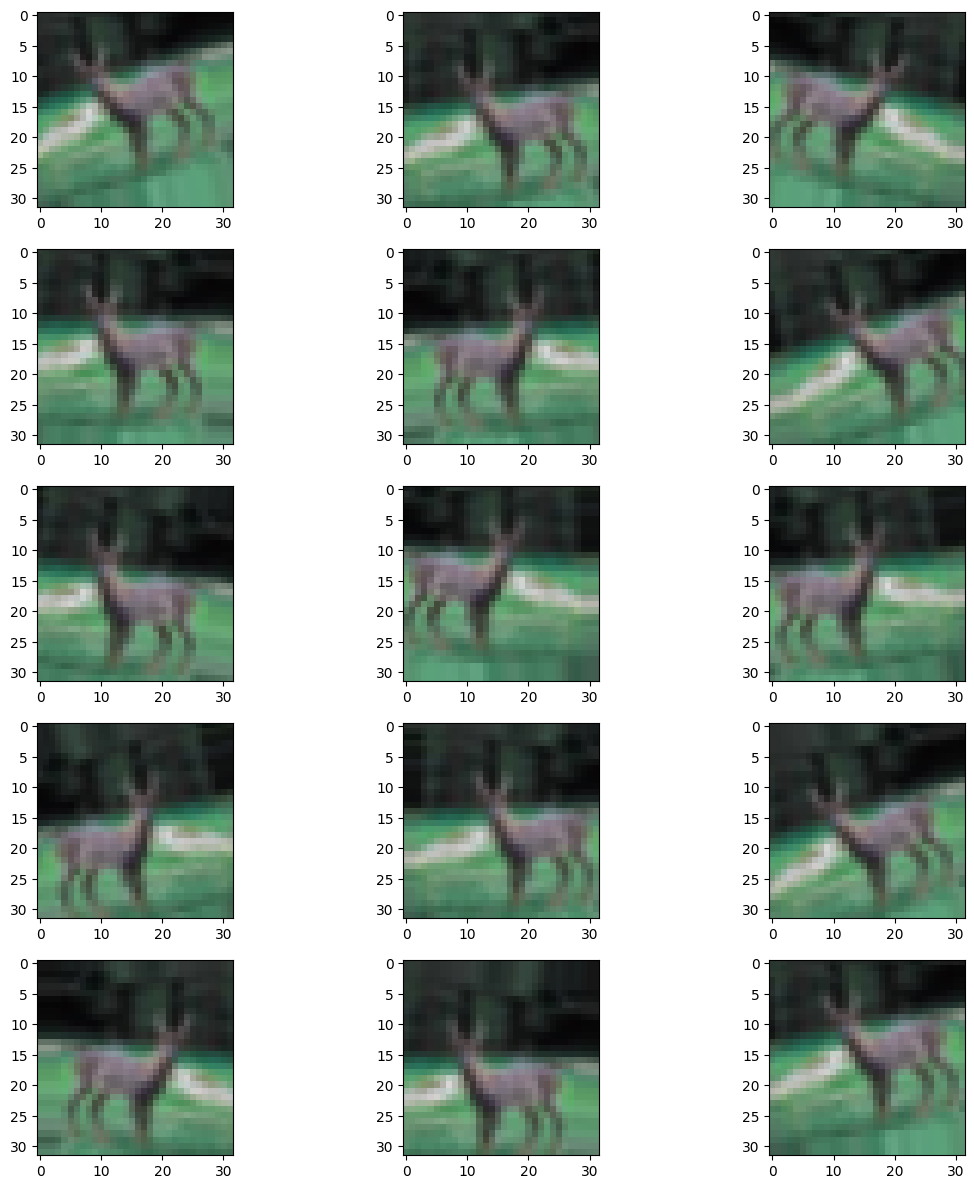

In [34]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X, Y in example_generator:
        image = X[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Entrenamiento

In [35]:
t = time.perf_counter()

In [36]:
# Data Augmentation:
history = model_post_xce.fit(train_generator, epochs=100,validation_data=validation_generator,callbacks=[modelcheckpoint_best_accuracy, earlystopping_val_loss,
                   earlystopping_val_accuracy],steps_per_epoch =200, validation_steps = 100)

Epoch 1/100
200/200 [==============================] - 507s 2s/step - loss: 0.7505 - accuracy: 0.7541 - val_loss: 0.3336 - val_accuracy: 0.8964
Epoch 2/100
200/200 [==============================] - 313s 2s/step - loss: 0.4247 - accuracy: 0.8592 - val_loss: 0.3066 - val_accuracy: 0.9016
Epoch 3/100
200/200 [==============================] - 307s 2s/step - loss: 0.3256 - accuracy: 0.8916 - val_loss: 0.2375 - val_accuracy: 0.9222
Epoch 4/100
200/200 [==============================] - 309s 2s/step - loss: 0.2659 - accuracy: 0.9103 - val_loss: 0.2259 - val_accuracy: 0.9274
Epoch 5/100
200/200 [==============================] - 306s 2s/step - loss: 0.2228 - accuracy: 0.9257 - val_loss: 0.2064 - val_accuracy: 0.9326
Epoch 6/100
200/200 [==============================] - 302s 2s/step - loss: 0.1824 - accuracy: 0.9392 - val_loss: 0.2299 - val_accuracy: 0.9297
Epoch 7/100
200/200 [==============================] - 302s 2s/step - loss: 0.1534 - accuracy: 0.9495 - val_loss: 0.2159 - val_accuracy:

In [37]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))
print('Tiempo de entrenamiento:', elapsed_time)

Tiempo de entrenamiento: 2:06:18.278563


## 6. Evaluamos los resultados

Obtengamos una grafica de como el error y la accuracy van evolucionando en cada epoch en los datos de entrenamiento y en la validación

In [38]:
_, acc = model_post_xce.evaluate(x_test_scaled, y_test_encoded, verbose=0)
print('Test del Modelo con Data Augmentation > %.3f' % (acc * 100.0))

Test del Modelo con Data Augmentation > 94.120


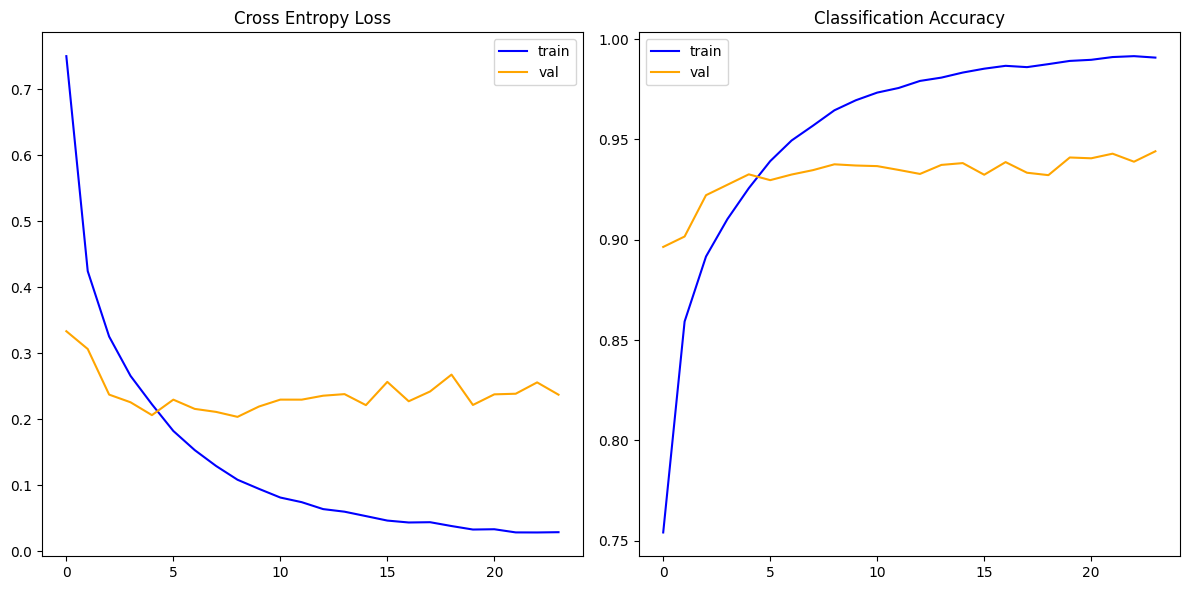

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Cross Entropy Loss
axs[0].set_title('Cross Entropy Loss')
axs[0].plot(history.history['loss'], color='blue', label='train')
axs[0].plot(history.history['val_loss'], color='orange', label='val')
axs[0].legend()

# Classification Accuracy
axs[1].set_title('Classification Accuracy')
axs[1].plot(history.history['accuracy'], color='blue', label='train')
axs[1].plot(history.history['val_accuracy'], color='orange', label='val')
axs[1].legend()

plt.tight_layout()
plt.show()

In [40]:
predictions = model_post_xce.predict(x_test_scaled)

313/313 [==============================] - 42s 126ms/step


Una de las ventajas de Python es que hay montones de funciones y código realizado por terceras personas. Aquí me he fusilado unas bonitas funciones (que he adaptado un poco a mis necesidades) para poder pintar las imagenes, su label (ground truth) y las clasificaciones que hemos realizado.

In [41]:
cifar10_labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


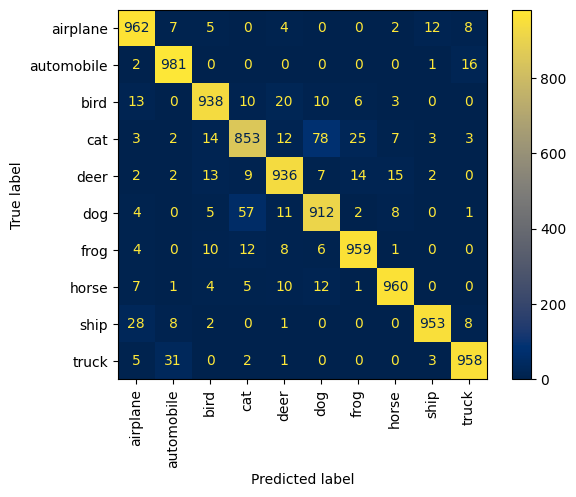

In [42]:
# Matriz de confusión
y_pred = np.argmax(predictions, axis=1)

confu_matrix = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_encoded, y_pred), display_labels=cifar10_labels)
confu_matrix.plot(xticks_rotation='vertical', cmap='cividis')
plt.show()

In [43]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


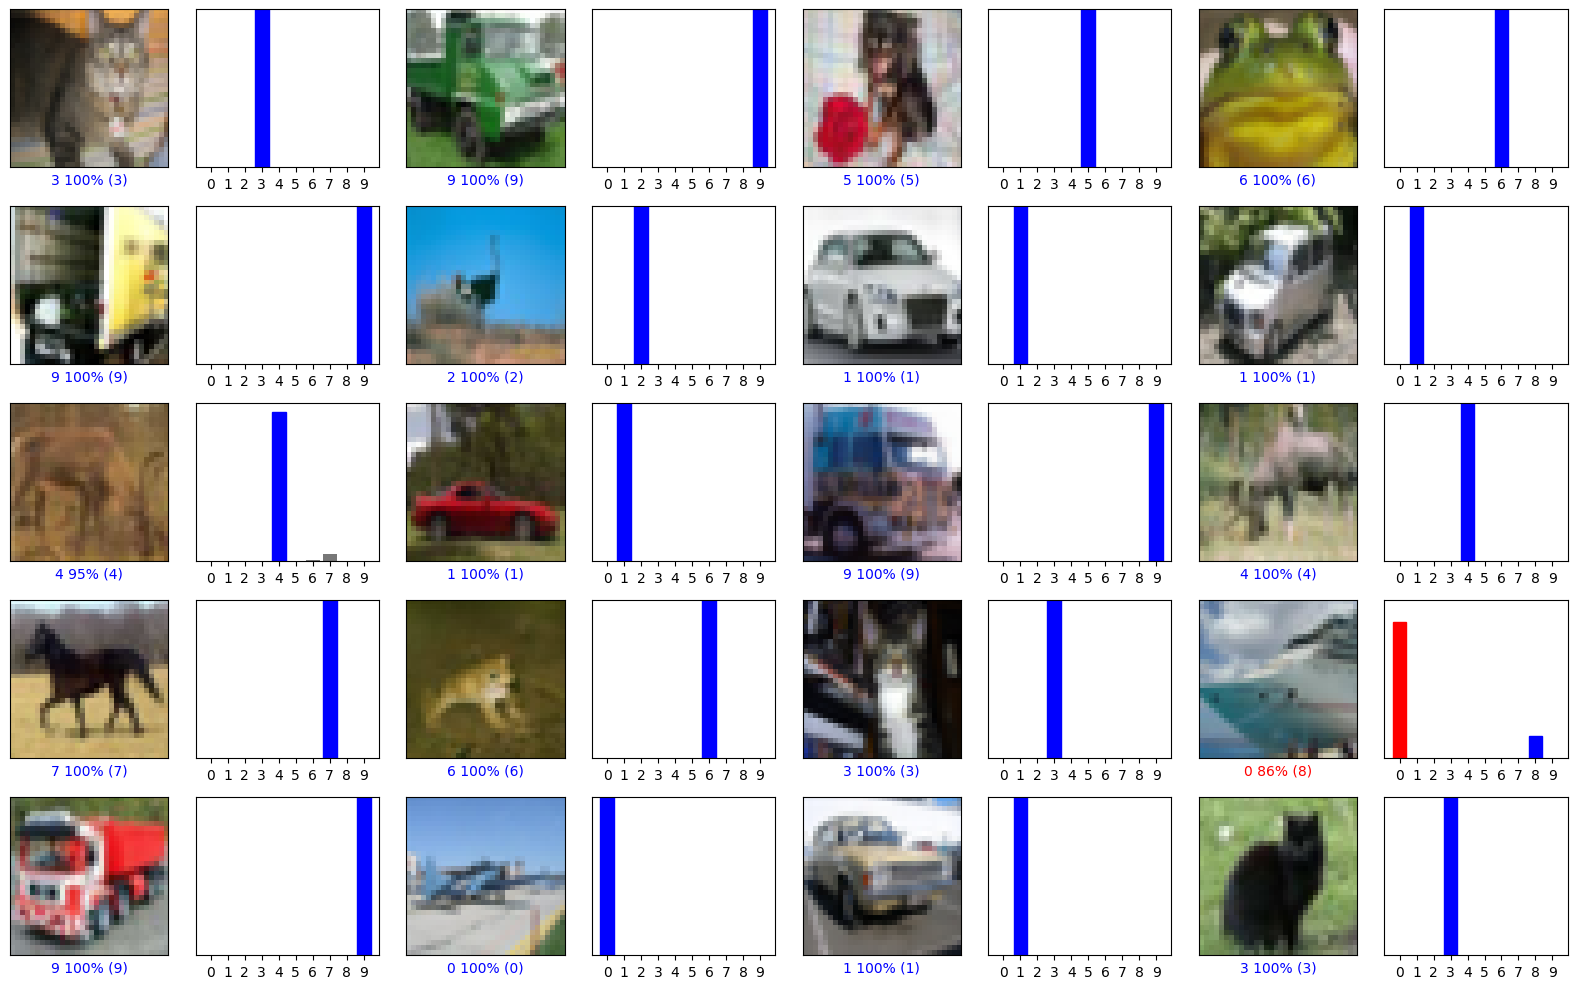

In [44]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test_encoded, x_test_scaled)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test_encoded)
plt.tight_layout()
plt.show()